In [1]:
# Importer
import classes.utils as utils
from classes.splitter import Splitter
from classes.classifier_trainer import ClassifierTrainer
from classes.drift_detector import DriftDetector
from classes.mlflow_manager import MLflowManager

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import numpy as np


utils.set_parent_directory_as_working_directory()

# TODO: Move this to a config file
# Importing
DATA_FOLDER = "./data"


FE_DATA_PATH = DATA_FOLDER +'/fe_data.csv'
DATES_DATA_PATH = DATA_FOLDER +'/dates_data.csv'

SEED = 47


# 0 Introduction
In this notebook we will develop our first model. We are going to assume that we have 1 year of loans that have finished (finished_d = issued date + total length of loan), which basically place ourselves on 2011-05-01.

We need to use this variable and not issued_date because when you issue new loan you don't know yet if it's going to be fully paid or not. So we need to wait until the loan is finished to know if it was fully paid or not.


# 1 Splitting data
Before we get hands on with the modelling, we need to split the data into train and test sets. As we mentioned in the preprocessing notebook we will be using the create variable  'finished_d' to 

We will use the train set to train the model and the test set to evaluate the model. We will use the train_test_split function from sklearn to split the data. We will use 80% of the data for training and 20% for testing.

In [2]:
splitter_name = "splitter"

splitter = Splitter(
    name = splitter_name
    , data_path = FE_DATA_PATH
    , date_cols = []
    , target_variable = 'loan_status'
    , destination_directory = DATA_FOLDER
    , dates_data_path = DATES_DATA_PATH
    , column_to_split_by = 'finished_d'
    , test_size = 0.3
    , random_state = SEED
)

splitter.execute()


-------------- Executing splitter --------------
Data loaded from ./data/fe_data.csv
Dates data loaded from ./data/dates_data.csv
Test and train attributes defined 0.3.
        Test size: 678201
        Train size: 1582467
--------------- splitter finished ---------------


This object contains x_train, x_test, y_train and y_test, for the whole series later we can filter them by changing "number_of_months".

# 2 Modelling with MLOps methodology

In this part is where we are going to dig deeper into MLOps methodology and simulate what the process could be imagining that we start modelling after we have 1 year of finished loans (i.e. since the first loan finished). 

The main focus areas on this exercise will be:
- Deploying the model in production: we will use MLflow to deploy the model in production, obviously in a real scenario this would be much more complex, but here we are just going to worry to serve the model in a API

- Monitoring the model in production: we can use the different MLflow tools for this

- Detecting drifts: after every year of data we are going to monitor the model and detect if there is any drift in the input or target variables as well as if there is a change in the relationship between the these both (concept drift)

- Retraining the model: lastly we will retrain our model. We will use the challenger model approach, which basically means that we will train a new model and compare it with the current model. If the challenger model is better than the current model, we will replace the current model with the challenger model

## 2.2 First year of data

In [3]:
# create a list of 5 random integers
random_max_depth = np.random.randint(2, 30, 5)
splitter.set_train_test_filtered(number_of_months=12)


trainer_first_year = ClassifierTrainer(
    name = 'trainer_first_year'
    , model_class = DecisionTreeClassifier()
    , random_state=SEED
    , splitter = splitter
    , objective_metric = 'roc_auc'
)

trainer_first_year.train_grid_search(
    param_distributions = {'max_depth': random_max_depth
                           }  
)

trainer_first_year.predict(splitter.X_test)
trainer_first_year.evaluate(splitter.y_test)


Date column finished_d added to the data
Data filtered by 0 and 12 months
Test and train attributes defined 0.3.
        Test size: 597
        Train size: 1393
Fitting grid search with 5 splits and 5 repeats
X_train shape: (1393, 132)
Best parameters: {'max_depth': 6}
Best cross-validation score: 0.58
Model trainer_first_year has made the predictions


Once the model has been trained and the predictions have been made on the test set we can see the metrics

In [29]:
trainer_first_year.results

{'accuracy': 0.5628140703517588,
 'precision': 0.8676470588235294,
 'recall': 0.5119305856832972,
 'f1': 0.6439290586630287,
 'roc_auc': 0.623612351665178}

In MLlow we can now log the experiment and model in MLflow. We are going to consider this model the model in production as well.

We need to initialize the MLflow tracking server
```bash
mlflow server --backend-store-uri sqlite:///mydb.sqlite
```

In this case I am doing it locally [using a sqlite database as a backend store](https://mlflow.org/docs/latest/tracking.html#scenario-3-mlflow-on-localhost-with-tracking-server).

URL: http://127.0.0.1:5000

We are going to register out previous model using the mlflow.sklearn log_model function. This function will log the model in MLflow and will save the model in the folder 'mlartifacts' which in this case is our modle store.

Some other things that we are doing when calling run method is that we are logging the parameters after predicting on test. Also, when logging the model in the model store, we are [infering the signature](https://mlflow.org/docs/latest/python_api/mlflow.models.html?highlight=infer_signature#mlflow.models.infer_signature) which means that when calling the model the input and output (predictions) format of the data will be checked.


In [30]:
experiment_name = 'random_forest'
mlflow_manager =  MLflowManager(
    name = 'mlflow_manager' 
)

mlflow_manager.make_run( run_name = 'first_year'
                        , experiment_name=experiment_name
                          , trainer=trainer_first_year
                          , log_model=True
                           )

Experiment random_forest created in tracking URI http://localhost:5000


c:\Users\Asus\.conda\envs\tfm\lib\site-packages\mlflow\models\signature.py:130: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
c:\Users\Asus\.conda\envs\tfm\lib\site-packages\mlflow\models\signature.py:131: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your inpu

Model trainer_first_year logged in MLflow
Run completed


Created version '2' of model 'trainer_first_year'.


We can see how this parameters are logged in the UI

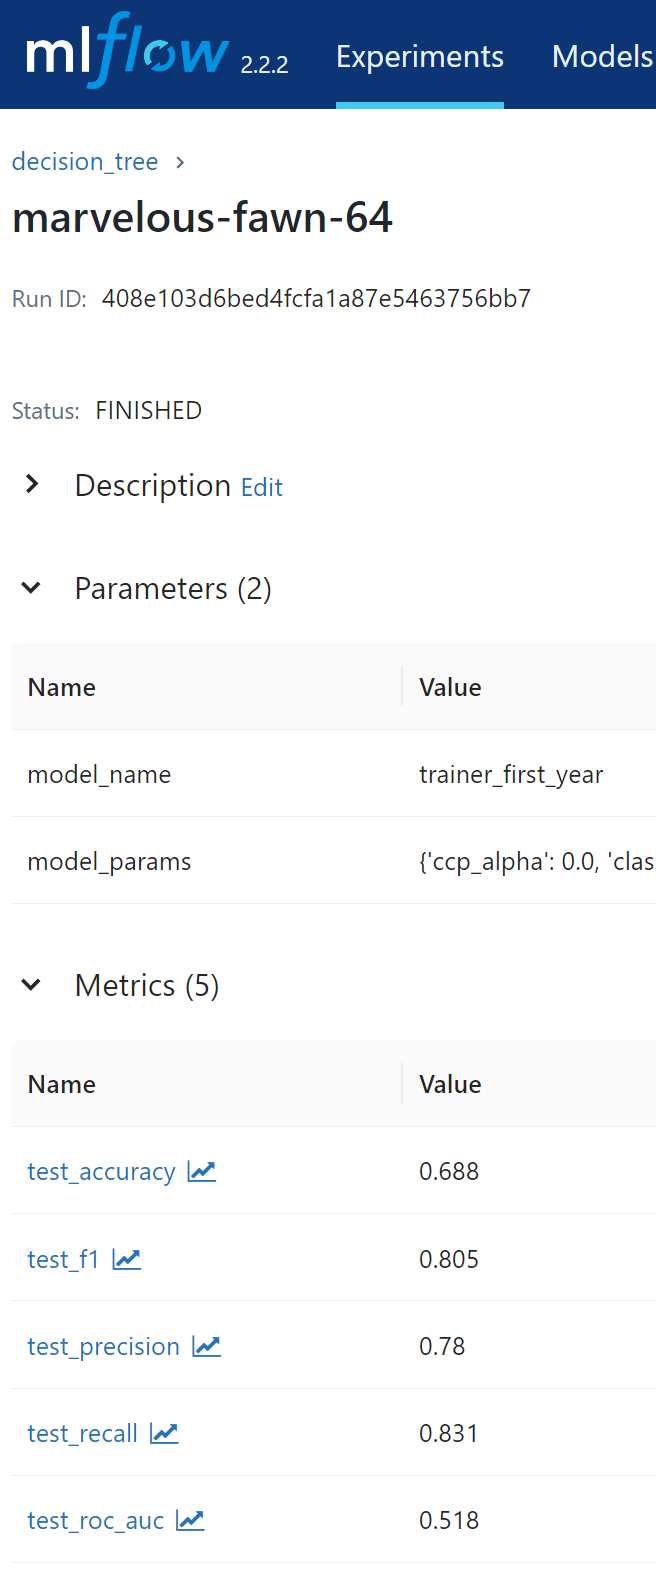

Let's set it as the production model

In [31]:
MLflowManager.set_model_production(trainer_first_year.name, model_version=1)

Now we can see how in the UI in the model section this model is set with the stage 'Production'

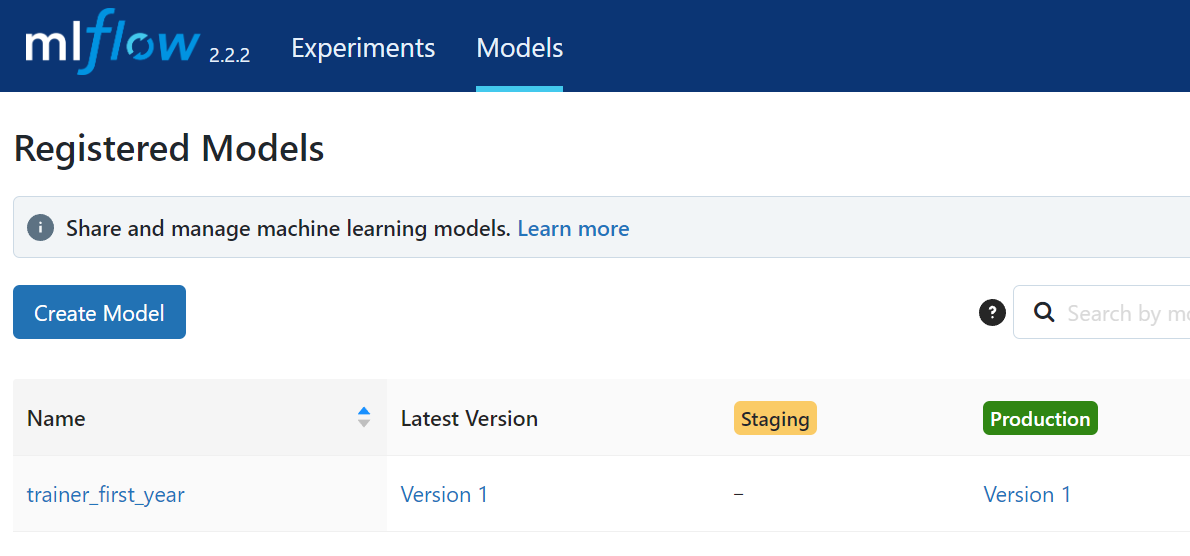

We can also load the model and make predictions

In [32]:
model = MLflowManager.load_model(trainer_first_year.name, '1', 'http://localhost:5000')
y_preds = model.predict(splitter.X_test)[:5]

Model trainer_first_year loaded from MLflow


So now we have trained a model after 1 year of data, as we mentioned we want to know track if this model is going to perform well on the new incoming data, in a real scenario we could track on daily basis if the input data is drifting and retrain a new model if necessary.

In this case as we already have all the data series, what we are going to do is analyze the drift and after every year rather than on a daily basis.

## 2.3 Second year of data

Imagine that a year has passed and we want to know if the data has changed during this time. Before retrain a new model we could check if the distribution of the input variables has changed

### 2.3.1 Input drift

There are many techniques to check if there is the X variable have drifted, but the idea basically is to check whether the distribution of a period t is equal to the one in period t+1. In this case we are going to use Kolmogorov-Smirnov test for numerical variables and Chi-square test for categorical variables.

There are many other tests and techniques, like train a [domain classifier](https://www.analyticsvidhya.com/blog/2021/10/mlops-and-the-importance-of-data-drift-detection/#:~:text=A%20Machine%20Learning,become%20computationally%20expensive.), to check if there is drift in the input variables, but for the sake of simplicity we are going to use these two. Please check out [this article](https://towardsdatascience.com/mlops-understanding-data-drift-69f9bf8a2e46) to dig deeper into this topic.

In [33]:
first_year_X,  first_year_y= splitter.x_y_filter_by_month(from_month=0, to_month=12)
second_year_X,  second_year_y= splitter.x_y_filter_by_month(from_month=12, to_month=24)


drift_detector = DriftDetector(
    name = 'drift_detector'
    , random_state=SEED
)

drifted_columns = drift_detector.univariate_input_drift(first_year_X, second_year_X)

Date column finished_d added to the data
Data filtered by 0 and 12 months
Date column finished_d added to the data
Data filtered by 12 and 24 months
kolmogorow_smirnov_test test


This only means that we need to retrain our model, but let's now check now if the target variable has changed

### 2.3.2 Target drift
As it's a categorical variable we are going to use the Chi-square test to check if the distribution of the target variable has changed.

In [34]:
p_value = DriftDetector.kolmogorow_smirnov_test(first_year_y, second_year_y)

if p_value < 0.05:
    print("Warning: target variable has drifted")

There is also drift in the target variable, so we need to retrain our model. Let's now check if there is concept drift.

### 2.3.3 Concept drift

There also many techniques also available but in this case I chose to just retrain a challenger model and compare it to our model in production. For simplicity and to test both models under the same conditions

In [56]:
splitter.set_train_test_filtered(number_of_months=24)

trainer_second_year = ClassifierTrainer(
    name = 'trainer_second_year'
    , model_class = RandomForestClassifier()
    , random_state=SEED
    , splitter = splitter
    , objective_metric = 'roc_auc'
)

trainer_second_year.set_model_params(
    params = trainer_first_year.params
)

trainer_second_year.train()
trainer_second_year.predict(splitter.X_test)
trainer_second_year.evaluate(splitter.y_test)

mlflow_manager.make_run(run_name='second_year'
                          , experiment_name=experiment_name
                          , trainer=trainer_second_year
                          , log_model=True
                          )

Date column finished_d added to the data
Data filtered from 2010-06-01 00:00:00 to 2015-06-01 00:00:00
Data filtered by 0 and 60 months
Test and train attributes defined 0.3.
        Test size: 13091
        Train size: 30544
X_train shape: (30544, 132)
Model trainer_second_year trained
Model trainer_second_year has made the predictions


"mlflow_manager.make_run(run_name='second_year'\n                          , experiment_name=experiment_name\n                          , trainer=trainer_second_year\n                          , log_model=True\n                          )"

If now we start comparing the with the data of the third year both models and the performance is significantly better for the challenger model, it can be an indicative of concept drift.

In [36]:
third_year_X, third_year_y = splitter.x_y_filter_by_month(from_month=24, to_month=36)


model_in_production = MLflowManager.load_model(trainer_first_year.name, '1', 'http://localhost:5000')
y_preds_production = model_in_production.predict(third_year_X)
metrics_production = ClassifierTrainer.get_metrics(third_year_y, y_preds_production)

mlflow_manager.log_new_metrics(run_name='first_year'
                               , experiment_name=experiment_name
                               , metrics=metrics_production
                               , prefix='Third_year_'
                               )
               

trainer_second_year.predict(third_year_X)
results = trainer_second_year.get_metrics(third_year_y, trainer_second_year.y_pred)
mlflow_manager.log_new_metrics(run_name='second_year'
                               , experiment_name=experiment_name
                               , metrics=trainer_second_year.results
                               , prefix='Third_year_'
                               )
               

print(f"""ROC-AUC for first year model: {trainer_first_year.results['roc_auc']}
ROC-AUC for second year model: {trainer_second_year.results['roc_auc']}""")


Date column finished_d added to the data
Data filtered by 24 and 36 months
Model trainer_first_year loaded from MLflow
Experiment random_forest created in tracking URI http://localhost:5000
New metrics logged in run first_year
Model trainer_second_year has made the predictions
Experiment random_forest created in tracking URI http://localhost:5000
New metrics logged in run second_year
ROC-AUC for first year model: 0.623612351665178
ROC-AUC for second year model: 0.5


In this case the challenger model doesn't seems to do much better than the production one, so we can assume that there is no concept drift.

In [4]:
import pandas as pd
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier

experiment_name = 'TEST2_decision_tree_whole_timeseries'

splitter = Splitter(
    name = "splitter"
    , data_path = FE_DATA_PATH
    , date_cols = []
    , target_variable = 'loan_status'
    , destination_directory = DATA_FOLDER
    , dates_data_path = DATES_DATA_PATH
    , column_to_split_by = 'finished_d'
    , test_size = 0.3
    , random_state = SEED
)
splitter.execute()

mlflow_manager =  MLflowManager(
    name = 'mlflow_manager' 
)

def choose_prod_challenger_model(prod, challenger, X, y,  objective_metric):

    prod_model_preds = prod.predict(X)
    challenger_model_preds = challenger.predict(X)

    prod_model_metrics = ClassifierTrainer.get_metrics(y, prod_model_preds)
    challenger_model_metrics = ClassifierTrainer.get_metrics(y, challenger_model_preds)

    is_challenger =  prod_model_metrics[objective_metric] < challenger_model_metrics[objective_metric]
    if is_challenger:
        print(f'- Challenger {objective_metric}: {challenger_model_metrics[objective_metric]}')
        print(f'- Prod {objective_metric}: {prod_model_metrics[objective_metric]}')
        print('Challenger model is better!')
    else:
        print(f'- Challenger {objective_metric}: {challenger_model_metrics[objective_metric]}')
        print(f'- Prod {objective_metric}: {prod_model_metrics[objective_metric]}')
        print('Prod model is better!')
    
    return  prod_model_metrics, challenger_model_metrics, is_challenger



def run_whole_timeseries(params
                         , splitter
                         , mlflow_manager
                         , step
                         , random_state
                         , model_class
                         , objective_metric= 'roc_auc'):

    start_date = splitter.dates_data['finished_d'].min()
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = splitter.dates_data['finished_d'].max()
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    prod_model_names = []
    months = step
    current_iteration = 1

    while start_date < end_date:

        print(f"""------------------ Iteration {current_iteration} started ------------------""")
        print(f"""Training model for {start_date} to {start_date + pd.DateOffset(months=step)}""")
        
        splitter.set_train_test_filtered(number_of_months=months)


        # Train new model
        model_name = f"model_{current_iteration}_year"
        trainer =  ClassifierTrainer(
            name = model_name
            , model_class = model_class
            , random_state=random_state
            , splitter = splitter
            , objective_metric = objective_metric
        )

        trainer.set_model_params(params)
        trainer.train()
        trainer.predict(splitter.X_test)
        trainer.evaluate(splitter.y_test)

        if current_iteration>=2:
            

            X_next_year, y_next_year = splitter.x_y_filter_by_month(from_month=months, to_month=months+step)
            
            if len(X_next_year) == 0:
                print('No more data for next year')
                break


            prod = MLflowManager.load_model(prod_model_names[-1], '1', 'http://localhost:5000')
            challenger = trainer.model_class

            prod_model_metrics, challenger_model_metrics, is_challenger = choose_prod_challenger_model(prod
                                                                             , challenger
                                                                             , X_next_year
                                                                             , y_next_year
                                                                             , objective_metric)
            

            if is_challenger:       
                prod_model_names.append(trainer.name)
                log_model = True
            else:
                log_model = False

            run_name = f"run_{current_iteration}_year"
            mlflow_manager.make_run(run_name=run_name
                        , experiment_name=experiment_name
                        , trainer=trainer
                        , log_model=log_model
                        )

            mlflow_manager.log_new_metrics(run_name= run_name
                            , experiment_name=experiment_name
                            , metrics= prod_model_metrics
                            , prefix='Production_next_year_'
                            )
            
            mlflow_manager.log_new_metrics(run_name= run_name
                                        , experiment_name=experiment_name
                                        , metrics= challenger_model_metrics
                                        , prefix='Challenger_next_year_'
                                        )
            
            if is_challenger:
                MLflowManager.set_model_production(trainer.name, model_version=1)

        else:
            
            run_name = f"run_{current_iteration}_year"

            mlflow_manager.make_run(run_name = run_name
                        , experiment_name=experiment_name
                          , trainer=trainer
                          , log_model=True
                           )
                           
            prod_model_names.append(trainer.name)

        months += step  
        start_date = start_date + pd.DateOffset(months=step)
        print(f"""------------------ Iteration {current_iteration} finished ------------------""")
        current_iteration += 1 

    return prod_model_metrics, prod_model_names

prod_model_metrics, prod_model_names = run_whole_timeseries(
                        params={'max_depth': 7}
                        , splitter=splitter
                        , mlflow_manager=mlflow_manager
                        , step=12
                        , random_state=SEED
                        , model_class=DecisionTreeClassifier()
                        )


-------------- Executing splitter --------------
Data loaded from ./data/fe_data.csv
Dates data loaded from ./data/dates_data.csv
Test and train attributes defined 0.3.
        Test size: 678201
        Train size: 1582467
--------------- splitter finished ---------------
------------------ Iteration 1 started ------------------
Training model for 2010-06-01 00:00:00 to 2011-06-01 00:00:00
Date column finished_d added to the data
Data filtered by 0 and 12 months
Resampled data. New train size: 1179
Test and train attributes defined 0.3.
        Test size: 597
        Train size: 1179
X_train shape: (1179, 132)
Model model_1_year trained
Model model_1_year has made the predictions


2023/05/14 21:04:10 INFO mlflow.tracking.fluent: Experiment with name 'TEST2_decision_tree_whole_timeseries' does not exist. Creating a new experiment.


Experiment TEST2_decision_tree_whole_timeseries created in tracking URI http://localhost:5000


c:\Users\Asus\.conda\envs\tfm\lib\site-packages\mlflow\models\signature.py:130: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
c:\Users\Asus\.conda\envs\tfm\lib\site-packages\mlflow\models\signature.py:131: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your inpu

Model model_1_year logged in MLflow
Run completed
------------------ Iteration 1 finished ------------------
------------------ Iteration 2 started ------------------
Training model for 2011-06-01 00:00:00 to 2012-06-01 00:00:00
Date column finished_d added to the data
Data filtered by 0 and 24 months
Resampled data. New train size: 2945
Test and train attributes defined 0.3.
        Test size: 1375
        Train size: 2945
X_train shape: (2945, 132)
Model model_2_year trained
Model model_2_year has made the predictions
Date column finished_d added to the data
Data filtered by 24 and 36 months
Model model_1_year loaded from MLflow
- Challenger roc_auc: 0.4971683106364884
- Prod roc_auc: 0.5022227349081745
Prod model is better!
Experiment TEST2_decision_tree_whole_timeseries created in tracking URI http://localhost:5000
Run completed
Experiment TEST2_decision_tree_whole_timeseries created in tracking URI http://localhost:5000
New metrics logged in run run_2_year
Experiment TEST2_decisio

c:\Users\Asus\.conda\envs\tfm\lib\site-packages\mlflow\models\signature.py:130: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
c:\Users\Asus\.conda\envs\tfm\lib\site-packages\mlflow\models\signature.py:131: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your inpu

Model model_3_year logged in MLflow
Run completed
Experiment TEST2_decision_tree_whole_timeseries created in tracking URI http://localhost:5000
New metrics logged in run run_3_year
Experiment TEST2_decision_tree_whole_timeseries created in tracking URI http://localhost:5000
New metrics logged in run run_3_year
------------------ Iteration 3 finished ------------------
------------------ Iteration 4 started ------------------
Training model for 2013-06-01 00:00:00 to 2014-06-01 00:00:00
Date column finished_d added to the data
Data filtered by 0 and 48 months
Resampled data. New train size: 15021
Test and train attributes defined 0.3.
        Test size: 6587
        Train size: 15021
X_train shape: (15021, 132)
Model model_4_year trained
Model model_4_year has made the predictions
Date column finished_d added to the data
Data filtered by 48 and 60 months
Model model_3_year loaded from MLflow
- Challenger roc_auc: 0.5861876831464665
- Prod roc_auc: 0.5
Challenger model is better!
Experim

c:\Users\Asus\.conda\envs\tfm\lib\site-packages\mlflow\models\signature.py:130: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
c:\Users\Asus\.conda\envs\tfm\lib\site-packages\mlflow\models\signature.py:131: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your inpu

Model model_4_year logged in MLflow
Run completed
Experiment TEST2_decision_tree_whole_timeseries created in tracking URI http://localhost:5000
New metrics logged in run run_4_year
Experiment TEST2_decision_tree_whole_timeseries created in tracking URI http://localhost:5000
New metrics logged in run run_4_year
------------------ Iteration 4 finished ------------------
------------------ Iteration 5 started ------------------
Training model for 2014-06-01 00:00:00 to 2015-06-01 00:00:00
Date column finished_d added to the data
Data filtered by 0 and 60 months
Resampled data. New train size: 30021
Test and train attributes defined 0.3.
        Test size: 13091
        Train size: 30021
X_train shape: (30021, 132)
Model model_5_year trained
Model model_5_year has made the predictions
Date column finished_d added to the data
Data filtered by 60 and 72 months
Model model_4_year loaded from MLflow
- Challenger roc_auc: 0.5658561463639071
- Prod roc_auc: 0.5665595898001615
Prod model is bette

c:\Users\Asus\.conda\envs\tfm\lib\site-packages\mlflow\models\signature.py:130: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
c:\Users\Asus\.conda\envs\tfm\lib\site-packages\mlflow\models\signature.py:131: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your inpu

Model model_7_year logged in MLflow
Run completed
Experiment TEST2_decision_tree_whole_timeseries created in tracking URI http://localhost:5000
New metrics logged in run run_7_year
Experiment TEST2_decision_tree_whole_timeseries created in tracking URI http://localhost:5000
New metrics logged in run run_7_year
------------------ Iteration 7 finished ------------------
------------------ Iteration 8 started ------------------
Training model for 2017-06-01 00:00:00 to 2018-06-01 00:00:00
Date column finished_d added to the data
Data filtered by 0 and 96 months
Resampled data. New train size: 316973
Test and train attributes defined 0.3.
        Test size: 141030
        Train size: 316973
X_train shape: (316973, 132)
Model model_8_year trained
Model model_8_year has made the predictions
Date column finished_d added to the data
Data filtered by 96 and 108 months
Model model_7_year loaded from MLflow
- Challenger roc_auc: 0.5748748889003645
- Prod roc_auc: 0.5576787032646122
Challenger mod

c:\Users\Asus\.conda\envs\tfm\lib\site-packages\mlflow\models\signature.py:130: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
c:\Users\Asus\.conda\envs\tfm\lib\site-packages\mlflow\models\signature.py:131: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your inpu

Model model_8_year logged in MLflow
Run completed
Experiment TEST2_decision_tree_whole_timeseries created in tracking URI http://localhost:5000
New metrics logged in run run_8_year
Experiment TEST2_decision_tree_whole_timeseries created in tracking URI http://localhost:5000
New metrics logged in run run_8_year
------------------ Iteration 8 finished ------------------
------------------ Iteration 9 started ------------------
Training model for 2018-06-01 00:00:00 to 2019-06-01 00:00:00
Date column finished_d added to the data
Data filtered by 0 and 108 months
Resampled data. New train size: 564547
Test and train attributes defined 0.3.
        Test size: 254295
        Train size: 564547
X_train shape: (564547, 132)
Model model_9_year trained
Model model_9_year has made the predictions
Date column finished_d added to the data
Data filtered by 108 and 120 months
Model model_8_year loaded from MLflow
- Challenger roc_auc: 0.606139041867318
- Prod roc_auc: 0.567827657350333
Challenger mod

c:\Users\Asus\.conda\envs\tfm\lib\site-packages\mlflow\models\signature.py:130: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
c:\Users\Asus\.conda\envs\tfm\lib\site-packages\mlflow\models\signature.py:131: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your inpu

Model model_9_year logged in MLflow
Run completed
Experiment TEST2_decision_tree_whole_timeseries created in tracking URI http://localhost:5000
New metrics logged in run run_9_year
Experiment TEST2_decision_tree_whole_timeseries created in tracking URI http://localhost:5000
New metrics logged in run run_9_year
------------------ Iteration 9 finished ------------------
------------------ Iteration 10 started ------------------
Training model for 2019-06-01 00:00:00 to 2020-06-01 00:00:00
Date column finished_d added to the data
Data filtered by 0 and 120 months
Resampled data. New train size: 825088
Test and train attributes defined 0.3.
        Test size: 373390
        Train size: 825088
X_train shape: (825088, 132)
Model model_10_year trained
Model model_10_year has made the predictions
Date column finished_d added to the data
Data filtered by 120 and 132 months
Model model_9_year loaded from MLflow
- Challenger roc_auc: 0.6286591595038951
- Prod roc_auc: 0.6336326559600308
Prod mode

c:\Users\Asus\.conda\envs\tfm\lib\site-packages\mlflow\models\signature.py:130: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
c:\Users\Asus\.conda\envs\tfm\lib\site-packages\mlflow\models\signature.py:131: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your inpu

Model model_11_year logged in MLflow
Run completed
Experiment TEST2_decision_tree_whole_timeseries created in tracking URI http://localhost:5000
New metrics logged in run run_11_year
Experiment TEST2_decision_tree_whole_timeseries created in tracking URI http://localhost:5000
New metrics logged in run run_11_year
------------------ Iteration 11 finished ------------------
------------------ Iteration 12 started ------------------
Training model for 2021-06-01 00:00:00 to 2022-06-01 00:00:00
Date column finished_d added to the data
Data filtered by 0 and 144 months
Resampled data. New train size: 1378867
Test and train attributes defined 0.3.
        Test size: 608805
        Train size: 1378867
X_train shape: (1378867, 132)
Model model_12_year trained
Model model_12_year has made the predictions
Date column finished_d added to the data
Data filtered by 144 and 156 months
Model model_11_year loaded from MLflow
- Challenger roc_auc: 0.536287718620616
- Prod roc_auc: 0.5674950960281724
Pr

c:\Users\Asus\.conda\envs\tfm\lib\site-packages\mlflow\models\signature.py:130: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
c:\Users\Asus\.conda\envs\tfm\lib\site-packages\mlflow\models\signature.py:131: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your inpu

Model model_13_year logged in MLflow
Run completed
Experiment TEST2_decision_tree_whole_timeseries created in tracking URI http://localhost:5000
New metrics logged in run run_13_year
Experiment TEST2_decision_tree_whole_timeseries created in tracking URI http://localhost:5000
New metrics logged in run run_13_year
------------------ Iteration 13 finished ------------------
------------------ Iteration 14 started ------------------
Training model for 2023-06-01 00:00:00 to 2024-06-01 00:00:00
Date column finished_d added to the data
Data filtered by 0 and 168 months
Resampled data. New train size: 1547880
Test and train attributes defined 0.3.
        Test size: 678201
        Train size: 1547880
X_train shape: (1547880, 132)
Model model_14_year trained
Model model_14_year has made the predictions
Date column finished_d added to the data
Data filtered by 168 and 180 months
No more data for next year


# HASTA AQUI!!!!!!!!!!!!!

In [2]:
splitter_name = "splitter"

splitter = Splitter(
    name = splitter_name
    , data_path = FE_DATA_PATH
    , date_cols = []
    , target_variable = 'loan_status'
    , destination_directory = DATA_FOLDER
    , dates_data_path = DATES_DATA_PATH
    , column_to_split_by = 'finished_d'
    , test_size = 0.3
    , random_state = SEED
)

splitter.execute()


-------------- Executing splitter --------------
Data loaded from ./data/fe_data.csv
Dates data loaded from ./data/dates_data.csv
Test and train attributes defined 0.3.
        Test size: 678201
        Train size: 1582467
--------------- splitter finished ---------------


Date column finished_d added to the data
Data filtered by 0 and 12 months
Test and train attributes defined 0.3.
        Test size: 597
        Train size: 1393
Date column finished_d added to the data
Data filtered by 0 and 48 months
Test and train attributes defined 0.3.
        Test size: 6587
        Train size: 15367
Date column finished_d added to the data
Data filtered by 48 and 60 months


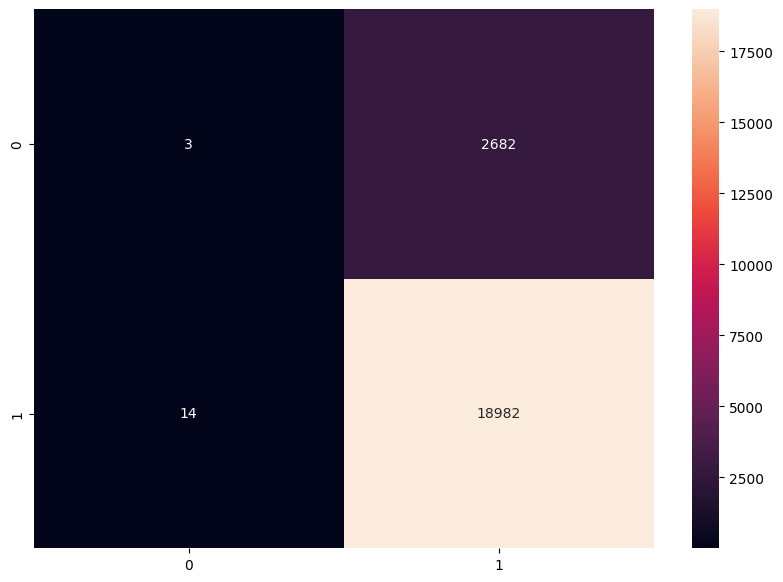

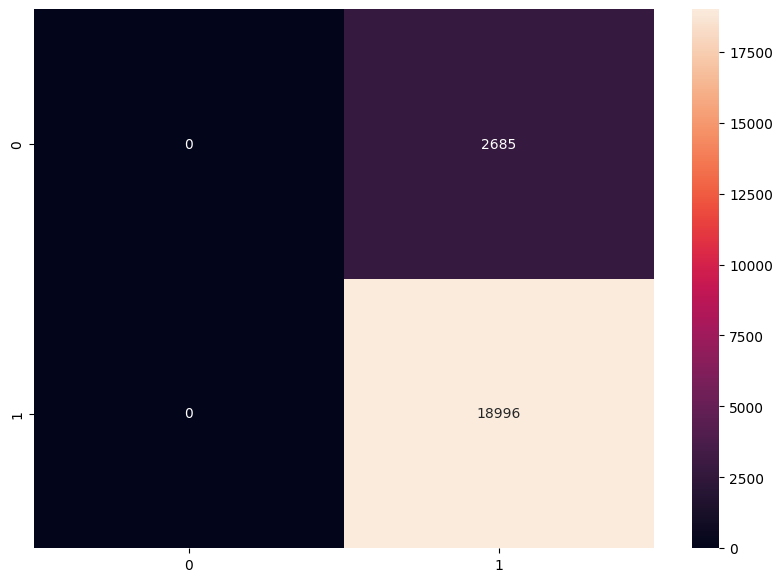

In [3]:
number_months = 48
params = {'max_depth': 7, 'n_estimators': 500}

model1 = RandomForestClassifier(**params)
model2 = RandomForestClassifier(**params)

splitter.set_train_test_filtered(number_of_months=12)
model1.fit(splitter.X_train, splitter.y_train)

splitter.set_train_test_filtered(number_of_months=number_months)
model2.fit(splitter.X_train, splitter.y_train)

next_year_X, next_year_y = splitter.x_y_filter_by_month(from_month=number_months, to_month=number_months+12)
y_preds_model1 = model1.predict(next_year_X)
y_preds_model2 = model2.predict(next_year_X)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

def plot_confussion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index = [i for i in "01"],
                      columns = [i for i in "01"])
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, fmt='g')
    plt.show()

plot_confussion_matrix(next_year_y, y_preds_model1)
plot_confussion_matrix(next_year_y, y_preds_model2)

Date column finished_d added to the data
Data filtered by 0 and 12 months
Test and train attributes defined 0.3.
        Test size: 597
        Train size: 1393
Date column finished_d added to the data
Data filtered by 0 and 48 months
Test and train attributes defined 0.3.
        Test size: 6587
        Train size: 15367
Date column finished_d added to the data
Data filtered by 48 and 60 months


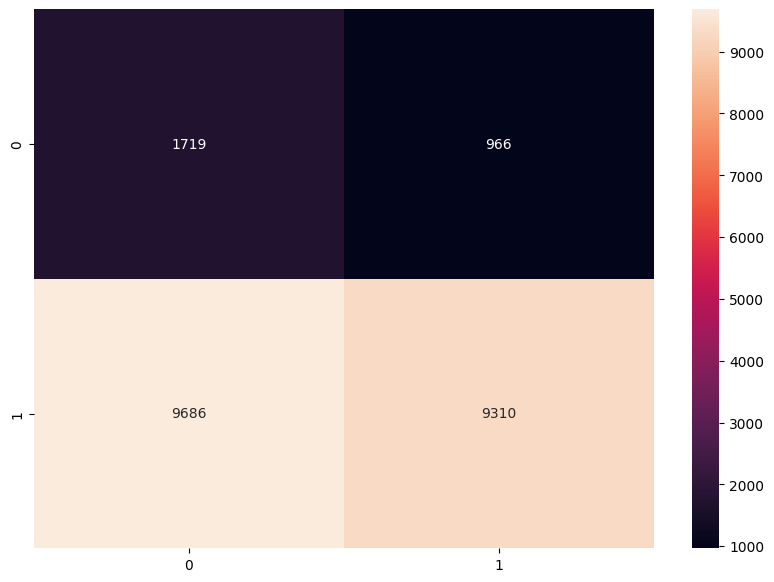

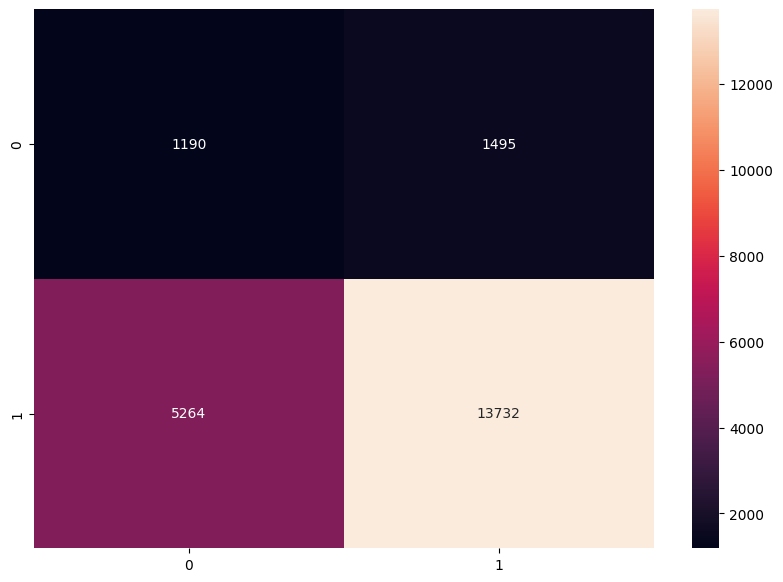

In [13]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

number_months = 48
params = {'max_depth': 7, 'n_estimators': 500}

def resample_data(X, y, over_sampling_strategy=0.5, under_sampling_strategy=0.8):

    smt = SMOTE(random_state=SEED, sampling_strategy=over_sampling_strategy)
    X, y = smt.fit_resample(X, y)
    under = RandomUnderSampler(sampling_strategy=under_sampling_strategy)
    X, y = under.fit_resample(X, y)

    return X, y


model1 = DecisionTreeClassifier(max_depth=7)
model2 = DecisionTreeClassifier(max_depth=7)

splitter.set_train_test_filtered(number_of_months=12)
x_model1, y_model1 = resample_data(splitter.X_train, splitter.y_train)
model1.fit(x_model1, y_model1)

splitter.set_train_test_filtered(number_of_months=number_months)
x_model2, y_model2 = resample_data(splitter.X_train, splitter.y_train)
model2.fit(x_model2, y_model2)

next_year_X, next_year_y = splitter.x_y_filter_by_month(from_month=number_months, to_month=number_months+12)
y_preds_model1 = model1.predict(next_year_X)
y_preds_model2 = model2.predict(next_year_X)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

def plot_confussion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index = [i for i in "01"],
                      columns = [i for i in "01"])
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, fmt='g')
    plt.show()

plot_confussion_matrix(next_year_y, y_preds_model1)
plot_confussion_matrix(next_year_y, y_preds_model2)

In [14]:
ClassifierTrainer.get_metrics(next_year_y, y_preds_model1)

{'accuracy': 0.5086942484202758,
 'precision': 0.9059945504087193,
 'recall': 0.4901031796167614,
 'f1': 0.6361027603170266,
 'roc_auc': 0.5651633216519562}

In [15]:
ClassifierTrainer.get_metrics(next_year_y, y_preds_model2)

{'accuracy': 0.6882523868825239,
 'precision': 0.9018191370591712,
 'recall': 0.7228890292693199,
 'f1': 0.8025012418548929,
 'roc_auc': 0.5830460043925743}

Date column finished_d added to the data
Data filtered by 0 and 12 months
Test and train attributes defined 0.3.
        Test size: 597
        Train size: 1393
Date column finished_d added to the data
Data filtered by 0 and 48 months
Test and train attributes defined 0.3.
        Test size: 6587
        Train size: 15367
Date column finished_d added to the data
Data filtered by 48 and 60 months


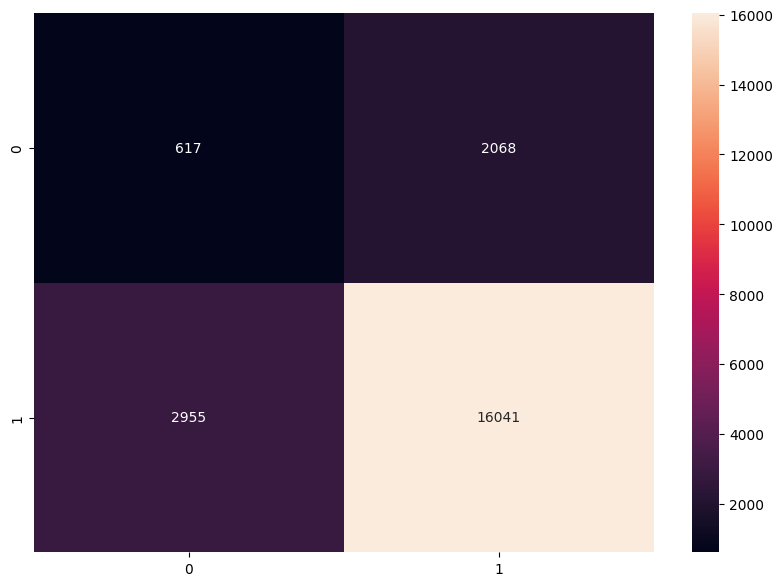

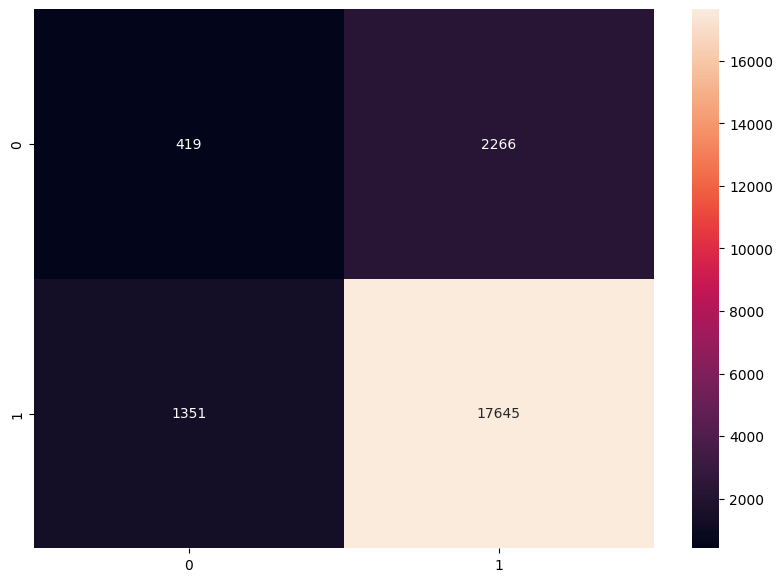

In [10]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

number_months = 48
params = {'max_depth': 7, 'n_estimators': 500}

def resample_data(X, y, over_sampling_strategy=0.5, under_sampling_strategy=0.8):

    smt = SMOTE(random_state=SEED, sampling_strategy=over_sampling_strategy)
    X, y = smt.fit_resample(X, y)
    under = RandomUnderSampler(sampling_strategy=under_sampling_strategy)
    X, y = under.fit_resample(X, y)

    return X, y


model1 = RandomForestClassifier(**params)
model2 = RandomForestClassifier(**params)

splitter.set_train_test_filtered(number_of_months=12)
x_model1, y_model1 = resample_data(splitter.X_train, splitter.y_train)
model1.fit(x_model1, y_model1)

splitter.set_train_test_filtered(number_of_months=number_months)
x_model2, y_model2 = resample_data(splitter.X_train, splitter.y_train)
model2.fit(x_model2, y_model2)

next_year_X, next_year_y = splitter.x_y_filter_by_month(from_month=number_months, to_month=number_months+12)
y_preds_model1 = model1.predict(next_year_X)
y_preds_model2 = model2.predict(next_year_X)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

def plot_confussion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index = [i for i in "01"],
                      columns = [i for i in "01"])
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, fmt='g')
    plt.show()

plot_confussion_matrix(next_year_y, y_preds_model1)
plot_confussion_matrix(next_year_y, y_preds_model2)